In [ ]:
!pip install yellowbrick

In [31]:
import pandas as pd
import numpy as np
import xlwings as xw
import glob
import os
import tsfel
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import chi2
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_validate, RandomizedSearchCV, cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import roc_curve,auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from yellowbrick.model_selection import validation_curve



### Data with signal

In [50]:
xl = r'C:\Users\emilh\Desktop\Data_split\Full data\AEPrec_sABRe_data_TPsABR21_BILATERAL_2021-Aug-18_13.09.55.xlsx'

try:
    excel_app=xw.App(visible=False)
    wb=excel_app.books.open(xl)
    for sheet in wb.sheets:
        sheet.api.Copy()
        wb_new=xw.books.active
        wb_new.save(f'{xl+sheet.name}.xlsx')
        wb_new.close()
finally:
    excel_app.quit()

In [24]:
cwd=os.chdir(r'C:\Users\emhm\Desktop\Data\Simp_Data')
files=os.listdir(cwd)

wsig=pd.DataFrame()
for file in files:
    if file.endswith('.xlsx'):
        wsig=wsig.append(pd.read_excel(file), ignore_index=True)

wsig.head()
wsig.insert(961, 'Label', '1')
wsig.to_excel('data.xlsx')

C:\Users\emhm\AppData\Local\Temp\ipykernel_22996\4193199951.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wsig=wsig.append(pd.read_excel(file), ignore_index=True)
C:\Users\emhm\AppData\Local\Temp\ipykernel_22996\4193199951.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wsig=wsig.append(pd.read_excel(file), ignore_index=True)
C:\Users\emhm\AppData\Local\Temp\ipykernel_22996\4193199951.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wsig=wsig.append(pd.read_excel(file), ignore_index=True)
C:\Users\emhm\AppData\Local\Temp\ipykernel_22996\4193199951.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  wsig=wsig.append(pd.read_

In [14]:
file = pd.read_excel(r'C:\Users\emhm\Desktop\Simp_Data\data.xlsx')
file.insert(960, 'Label', '1')

### Data without signal

In [9]:
no_sig=pd.read_excel(r'C:\Users\emhm\Desktop\Data\No_sig_data\ABR_Noise.xlsx')
no_sig.insert(960, 'Label', '0')
no_sig.to_excel('ABR_Noise_Edit.xlsx')

### Final data

In [26]:
cwd=os.chdir(r'C:\Users\emhm\Desktop\Final_Data')
files=os.listdir(cwd)

df_final=pd.concat([no_sig, wsig], axis=0)
df_final.to_excel('final_data.xlsx')

## Feature extraction

In [ ]:
data=pd.read_excel(r'C:\Users\emhm\Desktop\Final_Data\final_data.xlsx')
X=data.drop('Label', axis=1)
y=data.loc[:, 'Label']

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42)

print(X)

In [15]:
cfg = tsfel.get_features_by_domain()

feature_train = tsfel.time_series_features_extractor(cfg, x_train, fs=150)
feature_test = tsfel.time_series_features_extractor(cfg, x_test, fs=150)

*** Feature extraction started ***
60



*** Feature extraction finished ***
*** Feature extraction started ***
60



*** Feature extraction finished ***


In [16]:
feature_test

,0_Absolute energy,0_Area under the curve,0_Autocorrelation,0_Centroid,0_ECDF Percentile Count_0,0_ECDF Percentile Count_1,0_ECDF Percentile_0,0_ECDF Percentile_1,0_ECDF_0,0_ECDF_1,...,9_Wavelet variance_0,9_Wavelet variance_1,9_Wavelet variance_2,9_Wavelet variance_3,9_Wavelet variance_4,9_Wavelet variance_5,9_Wavelet variance_6,9_Wavelet variance_7,9_Wavelet variance_8,9_Zero crossing rate
0,145071.024888,11.981262,145071.024888,0.205214,14.0,56.0,-48.9777,9.4107,0.014085,0.028169,...,2383.803602,2729.432614,2592.93913,1597.643821,1203.763856,1174.781662,1259.39433,1366.64247,1442.214421,42.0


## Feature selection

In [18]:
X, y = make_classification(
    n_features=20,
    n_informative=3,
    n_redundant=0,
    n_classes=2,
    n_clusters_per_class=2,
    random_state=42,
)
X

array([[-1.05368242, -0.30317978,  1.9436449 , ...,  0.95030759,
         1.71061337, -0.7812514 ],
       [-1.7025836 ,  0.19584526, -0.32417081, ...,  0.47259748,
         0.25602973, -0.55605608],
       [ 0.98176549,  1.00981709,  1.46698424, ..., -2.49940571,
         2.29094257, -1.27589495],
       ...,
       [-0.67062021, -1.19363683,  2.17022234, ..., -0.25004651,
         0.28869363,  1.16926615],
       [-1.48489797,  0.43693817, -2.53167278, ...,  0.93431991,
        -1.3668787 , -1.31418743],
       [-0.92323325, -0.75538293, -1.01412848, ..., -0.97587325,
         1.0536418 , -0.93304205]])

### Chi-Square

## Accuracy functions

In [24]:
def get_confusion_matrix(y, y_pred, model):
    
    conf_matrix = confusion_matrix(y, y_pred)
    df_cm = pd.DataFrame(conf_matrix,index = ['Signal','No Signal'], columns = ['Signal','No Signal'])
    sns.set(font_scale = 1.4)
    sns.heatmap(df_cm, annot = True, cmap = 'OrRd', fmt = 'g', annot_kws={"size": 16}) # font size
    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.title('%s - Confusion Matrix' %model)
    #plt.savefig('confusion_matrix.png', dpi = 100, bbox_inches='tight' )
    plt.show()
    plt.close()

    return conf_matrix


def get_normalized_confusion_matrix(y, y_pred, model):
    
    conf_matrix = confusion_matrix(y, y_pred)
    conf_matrix = conf_matrix.astype(float)/conf_matrix.sum(axis = 1)[:,np.newaxis]
    df_cm = pd.DataFrame(conf_matrix,index = ['Signal','No Signal'], columns = ['Signal','No Signal'])
    sns.set(font_scale = 1.4)
    sns.heatmap(df_cm, annot = True, cmap = 'OrRd', fmt = '.2f',annot_kws={"size": 16}) # font size
    plt.ylabel('True labels')
    plt.xlabel('Predicted labels')
    plt.title('%s - Normalized Confusion Matrix' %model)
    #plt.savefig('confusion_matrix.png', dpi = 100, bbox_inches='tight' )
    plt.show()
    plt.close()
    
    return conf_matrix


# Based on Sensitivity and Recall 
# https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-019-6413-7
def get_matthews_corrcoef(y_pred, y_true):
    cov = np.cov(y_true, y_pred)
    if cov[0,0]==0. or cov[1,1]==0.:
        return 0.
    else:
        return cov[0,1]/np.sqrt(cov[0,0]*cov[1,1]) 
    
    
# Precision-Recall curve to evaluate a model
# PR curves are specifically tailored for the detection of rare events
def get_precision_recall_curve(y_true, y_pred):
    #precision, recall, thresholds = precision_recall_curve(y_test, probs)
    return plot_precision_recall_curve(classifier, X_test, y_test)
  
    
    
# ROC curves can sometimes be misleading in some very imbalanced applications
def get_roc_curve(y_true, y_pred_proba, model):
    
    #keep probabilities for the positive outcome only
    y_pred_proba = y_pred_proba[:,1]
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    
    auc = roc_auc_score(y_true, y_pred_proba)
    print('ROC AUC=%.3f' % (auc))
    
    plt.plot([0,1],[0,1],linestyle = '--',lw = 0.8,color = 'black', label='Luck')
    plt.plot(fpr, tpr, marker='.', lw=2, color='red', label=r'ROC (AUC = %0.3f )' % (auc))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(r'%s - ROC curve' % (model))
    plt.legend(loc = 'lower right')
    plt.show()
    
    return auc
    

## Random forrest

In [43]:
rf = RandomForestClassifier(random_state=42,  warm_start=True)

#### Find optimal number of estimators

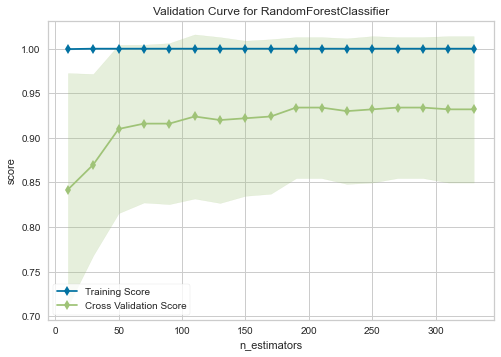

In [44]:
rfc = RandomForestClassifier(random_state=42,  warm_start=True)

viz = validation_curve(
    rfc, X, y, param_name="n_estimators",
    param_range=np.arange(10,350,20), cv=10, scoring="roc_auc",
)

#### Find optimal depth 

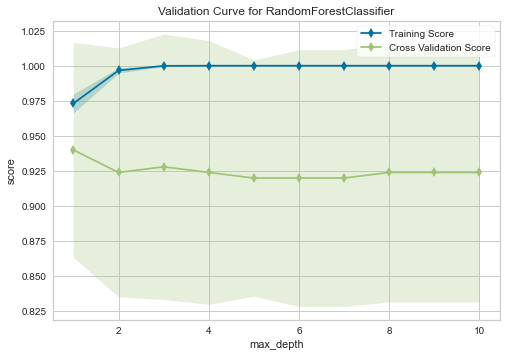

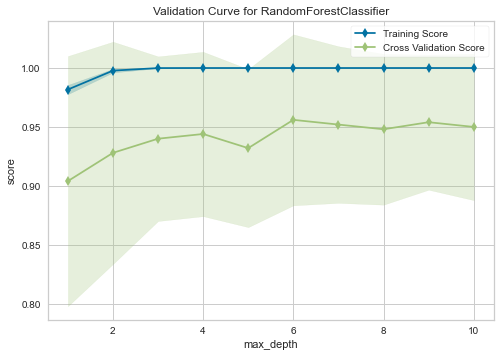

In [34]:
rfc = RandomForestClassifier(random_state=42,  warm_start=True,  n_estimators=110)

viz = validation_curve(
    rfc, X, y, param_name="max_depth",
    param_range=np.arange(1, 11), cv=10, scoring="roc_auc",
)

viz = validation_curve(
    rf, X, y, param_name="max_depth",
    param_range=np.arange(1, 11), cv=10, scoring="roc_auc",
)

#### Find best min_sample_leaf

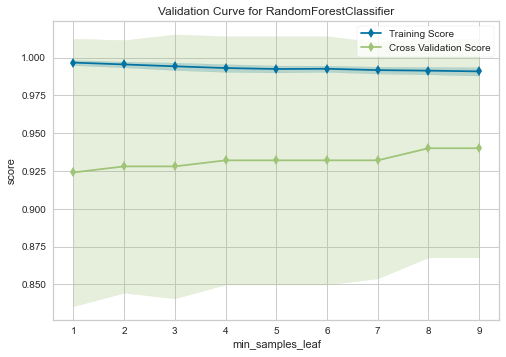

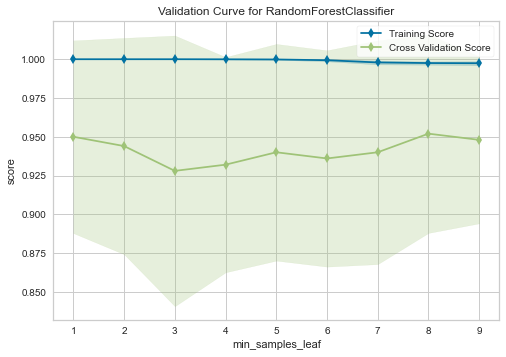

In [38]:
rfc = RandomForestClassifier(random_state=42,  warm_start=True, n_estimators=110, max_depth=2 )

viz = validation_curve(
    rfc, X, y, param_name="min_samples_leaf",
    param_range=np.arange(1, 10), cv=10, scoring="roc_auc",
)

viz = validation_curve(
    rf, X, y, param_name="min_samples_leaf",
    param_range=np.arange(1, 10), cv=10, scoring="roc_auc",
)

#### Find best max_features

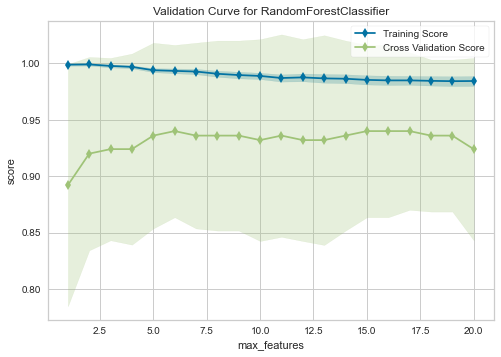

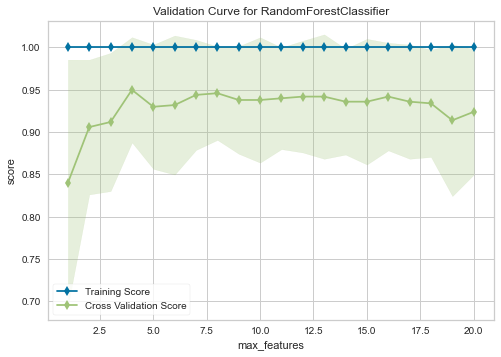

In [42]:
rfc = RandomForestClassifier(random_state=42,  warm_start=True,  n_estimators=400, max_depth=2 )

viz = validation_curve(
    rfc, X, y, param_name="max_features",
    param_range=np.arange(1, 400), cv=10, scoring="roc_auc",
)

viz = validation_curve(
    rf, X, y, param_name="max_features",
    param_range=np.arange(1, 400), cv=10, scoring="roc_auc",
)

#### Find best parametres with GridSearchCV

In [41]:
rf = RandomForestClassifier(random_state=42,  warm_start=True)
param_grid = {
    'n_estimators': [150, 200, 250, 300, 350, 400],
    'max_depth' : [2, 3, 4, 5, 6, 7, 8, 9],
    'min_samples_leaf' : [1, 2, 3, 4],
    'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
#    'criterion' :['gini', 'entropy']
             }
CV_rfc = GridSearchCV(estimator=rf,param_grid=param_grid,n_jobs = -1, scoring='roc_auc', cv= 10)
CV_rfc.fit(X_rfc, y_rfc)
print('BEST PARAMETERS:\n',CV_rfc.best_params_)
print('BEST SCORE:\n',CV_rfc.best_score_)

NameError: name 'rs' is not defined

MCC =  0.5241424183609592


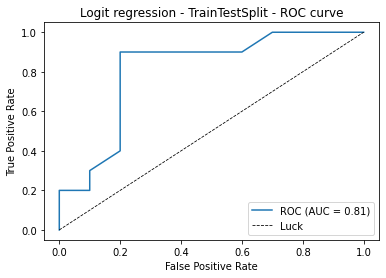

BEST PARAMETERS:
 {'n_estimators': 20, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 5, 'bootstrap': False}
BEST SCORE:
 0.9
[1.   1.   0.96 0.98 0.84 0.98 0.84 1.   0.9  1.  ]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
0.95


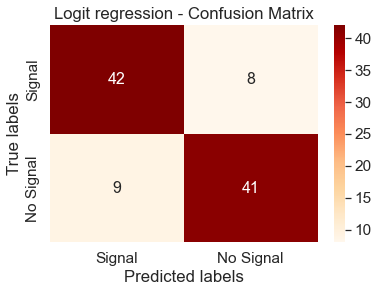

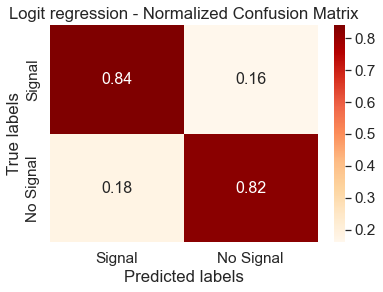

ROC AUC=0.927


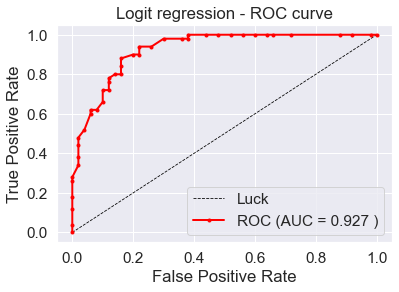

0.6601320396132041

In [27]:
param = {
    'bootstrap': [True, False],
    'max_depth': [1, 2, 2, 4, 5, 6, 7, 8, 9, 10],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [10,20,30,40,50,100],
}


# Instantiate logistic regression for parameters tuning
rf_clf = RandomForestClassifier(random_state = 2)

# Split the dataset into Test and Train parts 
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 91)

# Apply logistic regression model on train dataset
rf_clf.fit(X_train, y_train)
# Predict target variable values with X_test 
y_test_pred = rf_clf.predict(X_test)
# Predict target variable values with probabilities
y_test_pred_proba = rf_clf.predict_proba(X_test)[: ,1]

# Accuracy measure: Matthews Correlation Coefficient
mcc = get_matthews_corrcoef(y_test_pred, y_test)
print("MCC = ", mcc)

# Accuracy measure: ROC curve 
lr_precision, lr_recall, t =  roc_curve(y_test, y_test_pred_proba)
# Area Under the ROC Curve
roc_auc = auc(lr_precision, lr_recall)
# Plot ROC curve and AUC 
plt.plot(lr_precision, lr_recall, label='ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0,1],[0,1],linestyle = '--',lw = 0.8,color = 'black', label='Luck')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logit regression - TrainTestSplit - ROC curve')
plt.legend()
plt.show()
plt.close()


cv_logit = RandomizedSearchCV(rf_clf, param, cv = 10)
cv_logit.fit(X, y)

print('BEST PARAMETERS:\n',cv_logit.best_params_)
print('BEST SCORE:\n',cv_logit.best_score_)


# Instantiate logistic regression with optimized hyperParameters
logit_model = RandomForestClassifier()

cv_results = cross_validate(rf_clf, X, y, cv=10, scoring='roc_auc', return_train_score = True)
print(cv_results.get('test_score'))
print(cv_results.get('train_score'))
print(np.mean(cv_results.get('test_score')))

y_pred = cross_val_predict(rf_clf, X, y, cv=10)
y_pred_proba = cross_val_predict(rf_clf, X, y, cv=10, method='predict_proba')

get_confusion_matrix(y, y_pred,'Logit regression' )
get_normalized_confusion_matrix(y, y_pred,'Logit regression' )
get_roc_curve(y, y_pred_proba, 'Logit regression')
get_matthews_corrcoef(y_pred, y)

### Adaboost

In [13]:
ada_clf=AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                            n_estimators=100,
                            algorithm='SAMME',
                            learning_rate=1.0)

ada_clf.fit(X_train, y_train)

ada_clf.estimator_weights_

NameError: name 'X_train' is not defined

In [27]:
y_pred=ada_clf.predict(X_test)

accuracy_score(y_test, y_pred)

1.0

Adaboost 2# attempt